Yuhan Chen 3009389875

In [1]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
!pip install opencv-python

In [2]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy  as np
from numpy import array
import matplotlib.pyplot as plt
import os,pathlib,PIL
from tensorflow.keras import layers,models,Sequential,Input,Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization,ZeroPadding2D,Activation,AveragePooling2D

<generator object Path.glob at 0x7ff7d81a2740>

In [1]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


Randomly select ⌈0.7ni⌉ images from each folder as your training set, ⌈0.15ni⌉ as validation set, and the rest as your test set, where ni is the number of images in folder i and ⌈x⌉ is the ceiling of x.

In [4]:
import splitfolders
splitfolders.ratio('../data/images',output='../data/imagespliter',seed = 7, ratio=(.7,.15,.15)
                   ,group_prefix=None, move=False)

Copying files: 1176 files [00:01, 1062.19 files/s]


 Images in each class are given in separate folders. The file Classes.xlsx pro- vides the classes assigned to the bird species images in each folder. Therefore, you encode your classes using one-hot encoding and Classes.xlsx.

In [5]:
batch_size = 5
train_df = tf.keras.utils.image_dataset_from_directory('../data/imagespliter/train', 
                             image_size = (224,224),  batch_size=batch_size, labels = 'inferred',label_mode = 'categorical')
test_df = tf.keras.utils.image_dataset_from_directory('../data/imagespliter/test', 
                             image_size = (224,224), batch_size=batch_size,labels = 'inferred',label_mode = 'categorical')
validate_df = tf.keras.utils.image_dataset_from_directory('../data/imagespliter/val', 
                             image_size = (224,224), labels = 'inferred',batch_size=batch_size, label_mode = 'categorical')

Found 820 files belonging to 20 classes.
Found 185 files belonging to 20 classes.
Found 171 files belonging to 20 classes.


In [7]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: %d' % strategy.num_replicas_in_sync)  # 输出设备数量

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


i. Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization 4 and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

def build_model(num_classes):
    inputs = layers.Input(shape=(224, 224,3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
    model.trainable = False
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

with strategy.scope():
    model = build_model(num_classes=20)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(train_df, epochs=epochs, validation_data=validate_df, verbose=2)

Epoch 1/25
164/164 - 35s - loss: 2.1713 - accuracy: 0.6707 - val_loss: 0.7986 - val_accuracy: 0.8538 - 35s/epoch - 214ms/step
Epoch 2/25
164/164 - 30s - loss: 1.2077 - accuracy: 0.8329 - val_loss: 0.8662 - val_accuracy: 0.8596 - 30s/epoch - 183ms/step
Epoch 3/25
164/164 - 29s - loss: 0.5989 - accuracy: 0.9085 - val_loss: 1.2957 - val_accuracy: 0.8830 - 29s/epoch - 174ms/step
Epoch 4/25
164/164 - 29s - loss: 0.8014 - accuracy: 0.8927 - val_loss: 1.9323 - val_accuracy: 0.8538 - 29s/epoch - 174ms/step
Epoch 5/25
164/164 - 28s - loss: 0.7844 - accuracy: 0.9037 - val_loss: 2.0695 - val_accuracy: 0.8655 - 28s/epoch - 173ms/step
Epoch 6/25
164/164 - 28s - loss: 1.0609 - accuracy: 0.8854 - val_loss: 1.4910 - val_accuracy: 0.8830 - 28s/epoch - 173ms/step
Epoch 7/25
164/164 - 29s - loss: 0.6305 - accuracy: 0.9354 - val_loss: 2.0820 - val_accuracy: 0.8538 - 29s/epoch - 175ms/step
Epoch 8/25
164/164 - 217s - loss: 0.6254 - accuracy: 0.9329 - val_loss: 2.6753 - val_accuracy: 0.8538 - 217s/epoch - 1

NameError: name 'plot_hist' is not defined

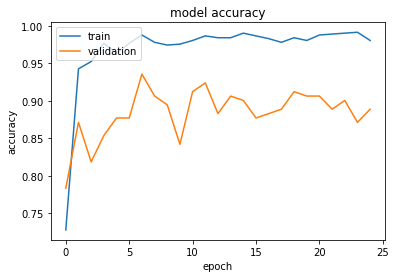

In [13]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [16]:
#early stop by min val_loss
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.callbacks import EarlyStopping
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=8, 
    min_delta=0.001, 
    mode='min'
)

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

Train the networks (EfficientNetB0 and VGG16) for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

EfficientNetB0

Epoch 1/50
164/164 - 39s - loss: 2.0889 - accuracy: 0.4939 - val_loss: 1.3839 - val_accuracy: 0.6082 - 39s/epoch - 238ms/step
Epoch 2/50
164/164 - 29s - loss: 1.0395 - accuracy: 0.7061 - val_loss: 0.7150 - val_accuracy: 0.7953 - 29s/epoch - 180ms/step
Epoch 3/50
164/164 - 30s - loss: 0.9068 - accuracy: 0.7549 - val_loss: 0.6610 - val_accuracy: 0.8363 - 30s/epoch - 184ms/step
Epoch 4/50
164/164 - 30s - loss: 0.9424 - accuracy: 0.7720 - val_loss: 0.5079 - val_accuracy: 0.8655 - 30s/epoch - 181ms/step
Epoch 5/50
164/164 - 32s - loss: 0.8291 - accuracy: 0.7927 - val_loss: 0.8295 - val_accuracy: 0.8187 - 32s/epoch - 192ms/step
Epoch 6/50
164/164 - 30s - loss: 0.8412 - accuracy: 0.8012 - val_loss: 1.0115 - val_accuracy: 0.8129 - 30s/epoch - 183ms/step
Epoch 7/50
164/164 - 30s - loss: 0.6682 - accuracy: 0.8183 - val_loss: 0.8752 - val_accuracy: 0.8070 - 30s/epoch - 184ms/step
Epoch 8/50
164/164 - 30s - loss: 0.7765 - accuracy: 0.8232 - val_loss: 0.7092 - val_accuracy: 0.8421 - 30s/epoch - 183

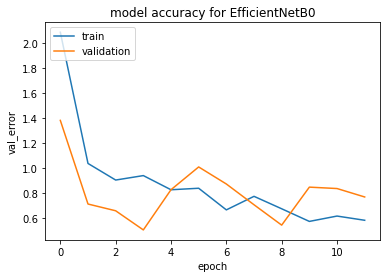

In [131]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

def build_model(num_classes):
    inputs = layers.Input(shape=(224,224,3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
    model.trainable = False
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    layerA_out = layers.Dense(num_classes,activation = 'relu')(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(layerA_out)
    model = tf.keras.Model(inputs, outputs, name="EfficientNetB0")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

with strategy.scope():
    model_EfficientNetB0 = build_model(num_classes=20)

epochs = 50  # @param {type: "slider", min:8, max:80}
hist = model_EfficientNetB0.fit(train_df, epochs=epochs, validation_data=validate_df, verbose=2,callbacks=[custom_early_stopping])

plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("model accuracy for EfficientNetB0")
plt.ylabel("val_error")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()


vgg16

Epoch 1/50
164/164 - 129s - loss: 2.6196 - accuracy: 0.2683 - val_loss: 1.7103 - val_accuracy: 0.4971 - 129s/epoch - 784ms/step
Epoch 2/50
164/164 - 128s - loss: 1.7218 - accuracy: 0.4659 - val_loss: 1.5342 - val_accuracy: 0.6199 - 128s/epoch - 778ms/step
Epoch 3/50
164/164 - 126s - loss: 1.5551 - accuracy: 0.5268 - val_loss: 1.1473 - val_accuracy: 0.6491 - 126s/epoch - 766ms/step
Epoch 4/50
164/164 - 129s - loss: 1.4110 - accuracy: 0.5829 - val_loss: 1.3635 - val_accuracy: 0.6140 - 129s/epoch - 784ms/step
Epoch 5/50
164/164 - 128s - loss: 1.3120 - accuracy: 0.6098 - val_loss: 1.4402 - val_accuracy: 0.6433 - 128s/epoch - 780ms/step
Epoch 6/50
164/164 - 127s - loss: 1.2754 - accuracy: 0.6134 - val_loss: 1.2786 - val_accuracy: 0.6550 - 127s/epoch - 776ms/step
Epoch 7/50
164/164 - 133s - loss: 1.1839 - accuracy: 0.6488 - val_loss: 1.2635 - val_accuracy: 0.6550 - 133s/epoch - 813ms/step
Epoch 8/50
164/164 - 130s - loss: 1.2767 - accuracy: 0.6378 - val_loss: 1.0024 - val_accuracy: 0.7485 - 

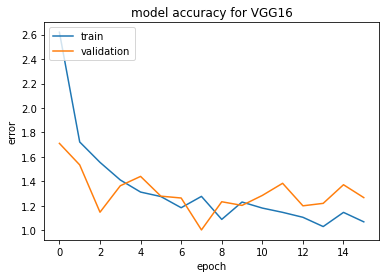

In [132]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from tensorflow.keras import activations

def build_model(num_classes):
    inputs = layers.Input(shape=(224, 224, 3))
    x = img_augmentation(inputs)
    model = VGG16(include_top=False, input_tensor=inputs, weights="imagenet")
    model.trainable = False
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    layerA_out = layers.Dense(num_classes,activation = 'relu')(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(layerA_out)
    model = tf.keras.Model(inputs, outputs, name="VGG16")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

with strategy.scope():
    
    model_vgg16 = build_model(num_classes=20)

epochs = 50  # @param {type: "slider", min:8, max:80}
hist = model_vgg16.fit(train_df, epochs=epochs, validation_data=validate_df, verbose=2,callbacks=[custom_early_stopping])
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("model accuracy for VGG16")
plt.ylabel("error")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

Report Precision, Recall, and F1 score for your model. Remember that this is a multi-class classification problem.

In [133]:
test_pre = model_EfficientNetB0.predict(test_df)

37/37 [==============================] - 7s 140ms/step


In [134]:
test_pre_vgg = model_vgg16.predict(test_df)

37/37 [==============================] - 23s 626ms/step


In [135]:
from keras.preprocessing.image import ImageDataGenerator

height=224
width=224
batch_size=5

test_datagen = ImageDataGenerator(rescale=1./224)

test_generator = test_datagen.flow_from_directory(
        '../data/imagespliter/test',
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')


Found 185 images belonging to 20 classes.


In [154]:
import numpy
pre_label =[]
for i in range(185):
    test_pre[i].tolist()
    max_value = max(test_pre[i].tolist())
    index = test_pre[i].tolist().index(max_value)
    pre_label.append(index)
pre_label = numpy.array(pre_label)

In [64]:
from sklearn.metrics import classification_report

In [151]:
true_label = test_generator.classes

In [152]:
true_label

array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,
        9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19],
      dtype=int32)

In [155]:
pre_label

array([19, 17,  8, 14,  8, 12,  9,  5, 15, 13,  3, 13, 14, 10, 11,  9, 15,
       11, 15, 16,  2,  0,  6, 10, 19,  9,  3,  7,  2,  9, 14,  5, 10, 18,
        7, 17,  0,  6, 13,  3,  3, 16, 11,  4,  0, 10, 19,  3,  4, 10, 12,
        1,  8,  7, 17,  9,  7, 15,  8, 17,  6,  7, 15,  8,  6, 14,  8,  5,
        1,  2,  6,  4, 18, 12,  3,  1,  5, 14,  2,  3, 12,  2, 19,  3,  2,
       19,  7,  2,  2, 10,  7, 15, 16, 13, 11,  1, 11,  0,  2, 16, 14,  1,
       14,  4,  8,  2,  0,  2, 13, 11,  4, 18,  1, 16, 10,  4, 15,  1,  1,
       10,  5, 19,  4,  5,  4,  8, 12,  4, 11, 16, 11,  6,  3, 14, 11,  2,
        7,  6, 11, 18, 17,  0,  2,  8, 16, 19, 14,  2, 15,  5, 14,  5, 11,
        7, 14,  1, 17,  7, 14,  1, 16,  5, 17,  6,  9,  0,  2,  9, 12,  2,
       10, 16,  2, 12,  1,  8, 17,  9, 10, 16,  5,  6, 13,  4, 17])

In [158]:
class_info = pd.read_excel('../data/Classes.xlsx')
class_name = class_info.iloc[:,0].values.tolist()

EfficientNetB0 precision recall f1-score

In [160]:
print(classification_report(true_label, pre_label,target_names=class_name))

                               precision    recall  f1-score   support

           005.Crested_Auklet       0.00      0.00      0.00         8
                 013.Bobolink       0.00      0.00      0.00         9
           015.Lazuli_Bunting       0.06      0.10      0.07        10
         023.Brandt_Cormorant       0.00      0.00      0.00        10
   040.Olive_sided_Flycatcher       0.10      0.11      0.11         9
041.Scissor_tailed_Flycatcher       0.00      0.00      0.00         9
         067.Anna_Hummingbird       0.11      0.11      0.11         9
          072.Pomarine_Jaeger       0.00      0.00      0.00         9
          076.Dark_eyed_Junco       0.00      0.00      0.00         9
          081.Pied_Kingfisher       0.00      0.00      0.00         9
        082.Ringed_Kingfisher       0.00      0.00      0.00         9
             086.Pacific_Loon       0.00      0.00      0.00         9
                 099.Ovenbird       0.00      0.00      0.00         9
     

In [168]:
test_pre_vgg = model_vgg16.predict(test_df)

37/37 [==============================] - 22s 594ms/step


VGG‘s precision    recall  f1-score 

In [169]:
import numpy
pre_label_vgg =[]
for i in range(185):
    test_pre_vgg[i].tolist()
    max_value = max(test_pre_vgg[i].tolist())
    index = test_pre_vgg[i].tolist().index(max_value)
    pre_label_vgg.append(index)
pre_label_vgg = numpy.array(pre_label_vgg)

In [170]:
print(classification_report(true_label, pre_label_vgg,target_names=class_name))

                               precision    recall  f1-score   support

           005.Crested_Auklet       0.11      0.12      0.12         8
                 013.Bobolink       0.11      0.11      0.11         9
           015.Lazuli_Bunting       0.22      0.20      0.21        10
         023.Brandt_Cormorant       0.00      0.00      0.00        10
   040.Olive_sided_Flycatcher       0.00      0.00      0.00         9
041.Scissor_tailed_Flycatcher       0.00      0.00      0.00         9
         067.Anna_Hummingbird       0.11      0.11      0.11         9
          072.Pomarine_Jaeger       0.00      0.00      0.00         9
          076.Dark_eyed_Junco       0.00      0.00      0.00         9
          081.Pied_Kingfisher       0.00      0.00      0.00         9
        082.Ringed_Kingfisher       0.00      0.00      0.00         9
             086.Pacific_Loon       0.22      0.22      0.22         9
                 099.Ovenbird       0.00      0.00      0.00         9
     